# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [5]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [6]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

/Users/matthewwong/anaconda3/lib/python3.7/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [7]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/Users/matthewwong/anaconda3/lib/python3.7/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [13]:
#merge dataframes into one dataframe
df = pd.merge(df_offers,df_transactions)
df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [40]:
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
matrix.fillna(0,inplace=True)
matrix.reset_index(inplace=True)

matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [114]:
x_cols1 = matrix.columns[1:]
x_cols1

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype='object', name='offer_id')

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>

</div>

<div class="span5 alert alert-success">

What values of $SS$ do you believe represent better clusterings? Why? 

The sum-of-squares is dependent on the number of K, clusters. Lower the number of clusters the higher the sum-of-squares, and visa versa. Higher clusters result in lower sum-of-squares. The sum-of-squares value that represents the best clustering is the value indicated by the elbow of the graph. 
</div>

In [133]:
# your turn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np



In [146]:
x_cols = np.matrix(matrix.iloc[:,1:])

In [276]:
ssd = [ ]
data = x_cols
K = np.arange(2,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data)
    ssd.append(km.inertia_)
 

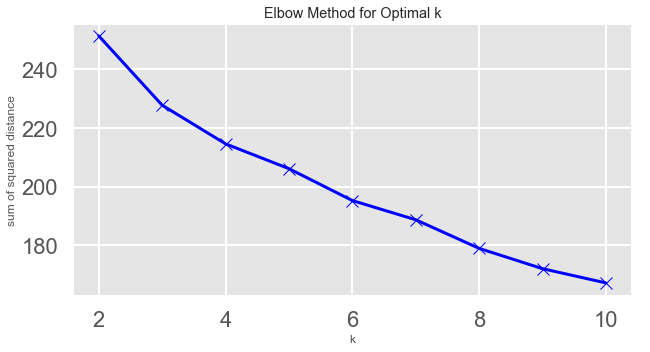

In [277]:
plt.figure(figsize=(10,5))
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('sum of squared distance')
plt.title('Elbow Method for Optimal k')
plt.show()

<div class="span5 alert alert-success">

The graph above shows SS with number of clusters (2 to 10) That problem we have with this method is we do not see a clear elbow. The elbow can potentially be 3. 

</div>

Text(0,0.5,'Number of people')

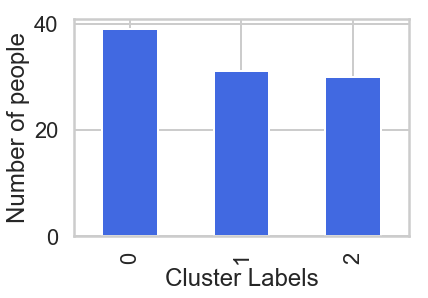

In [175]:
best_model = KMeans(n_clusters=3)
clusters = best_model.fit_predict(x_cols)
s = pd.Series(clusters)
s.groupby(s.values).size().plot(kind='bar', color = 'royalblue')
plt.xlabel('Cluster Labels')
plt.ylabel('Number of people')

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [176]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

For n_clusters = 2 The average silhouette_score is : 0.09365573283492713
For n_clusters = 3 The average silhouette_score is : 0.11889942863638556
For n_clusters = 4 The average silhouette_score is : 0.12347053919571699
For n_clusters = 5 The average silhouette_score is : 0.14092516241984757
For n_clusters = 6 The average silhouette_score is : 0.1371798939109807
For n_clusters = 7 The average silhouette_score is : 0.1161092456616906
For n_clusters = 8 The average silhouette_score is : 0.11339573832632867
For n_clusters = 9 The average silhouette_score is : 0.12505960527779877
For n_clusters = 10 The average silhouette_score is : 0.11928332134753233


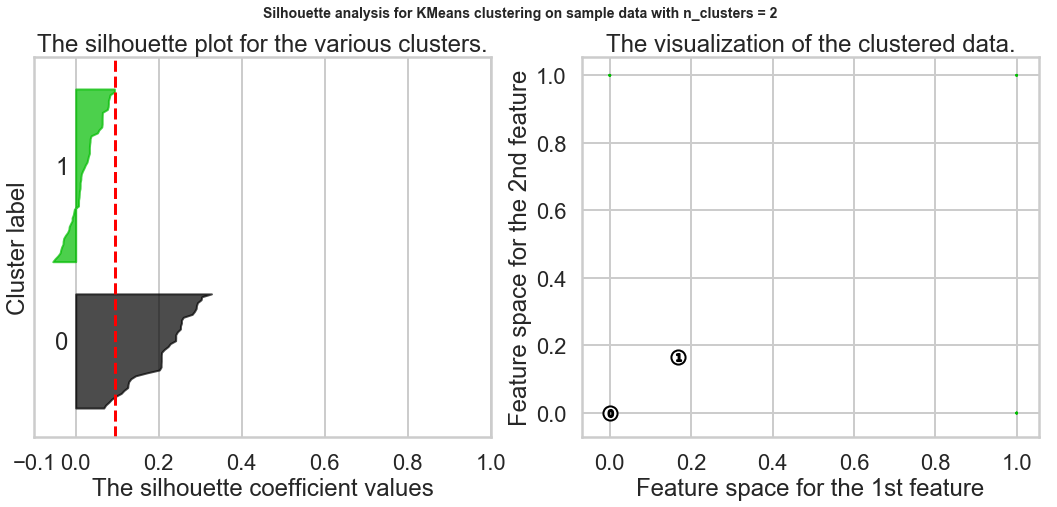

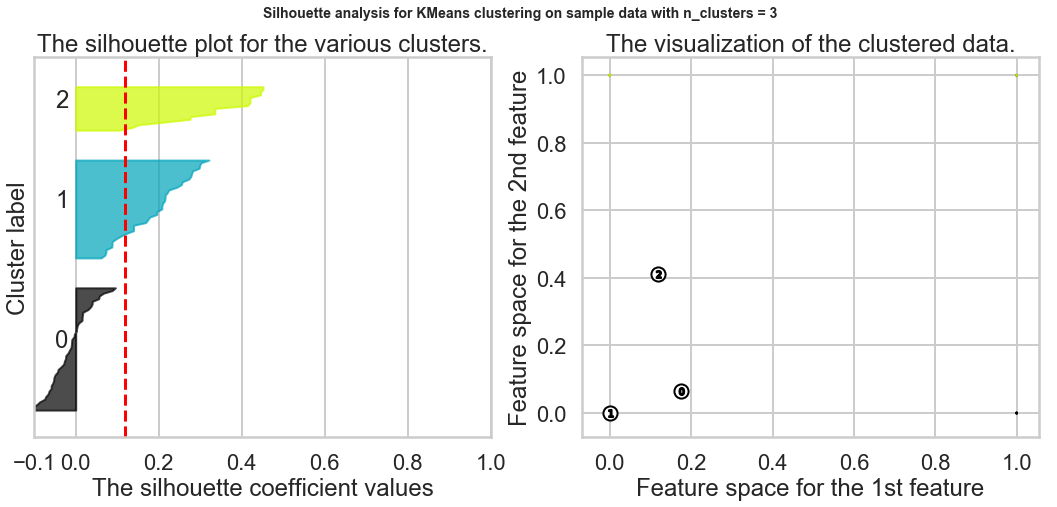

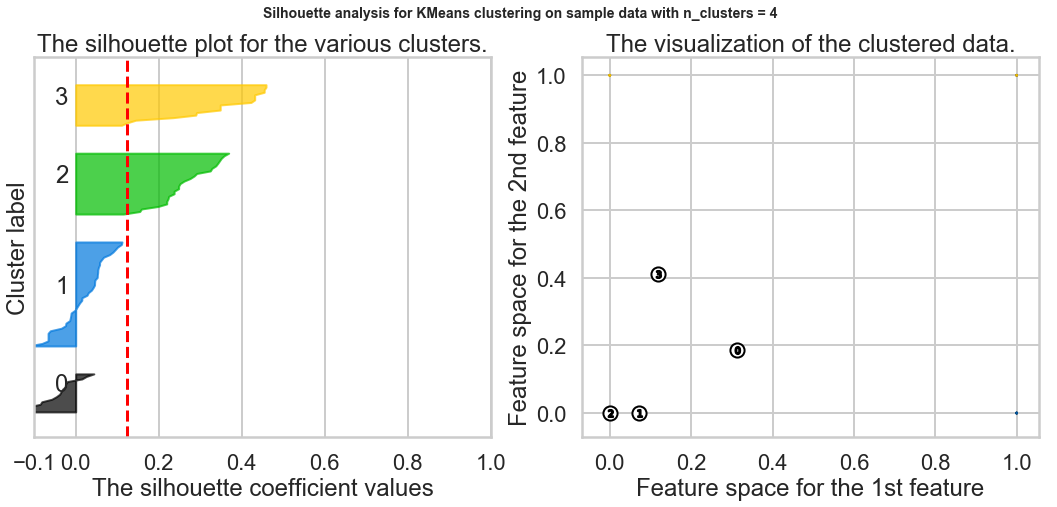

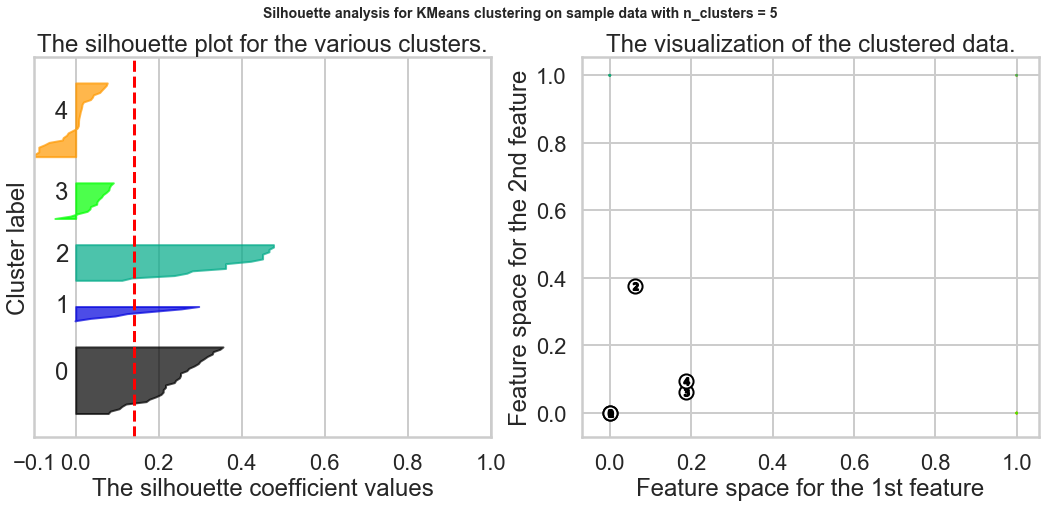

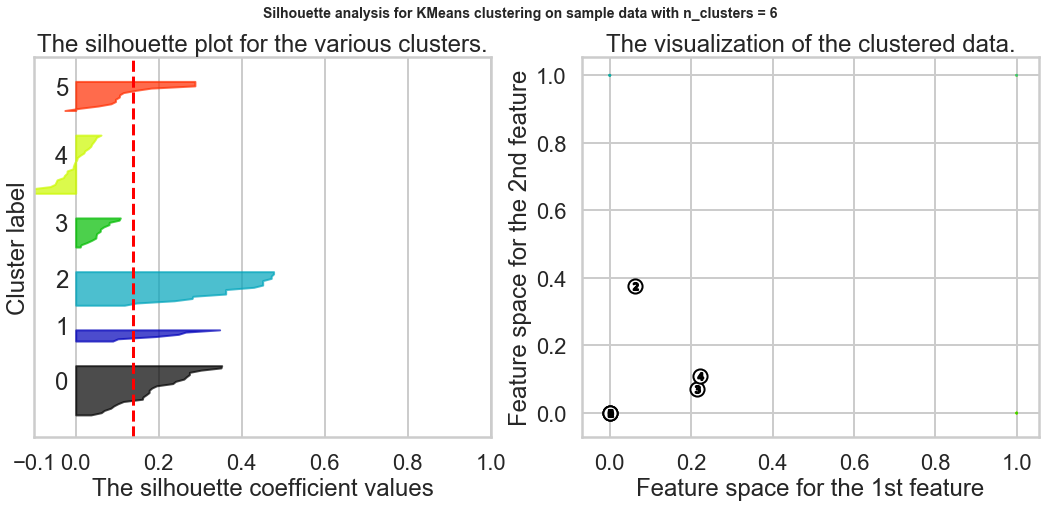

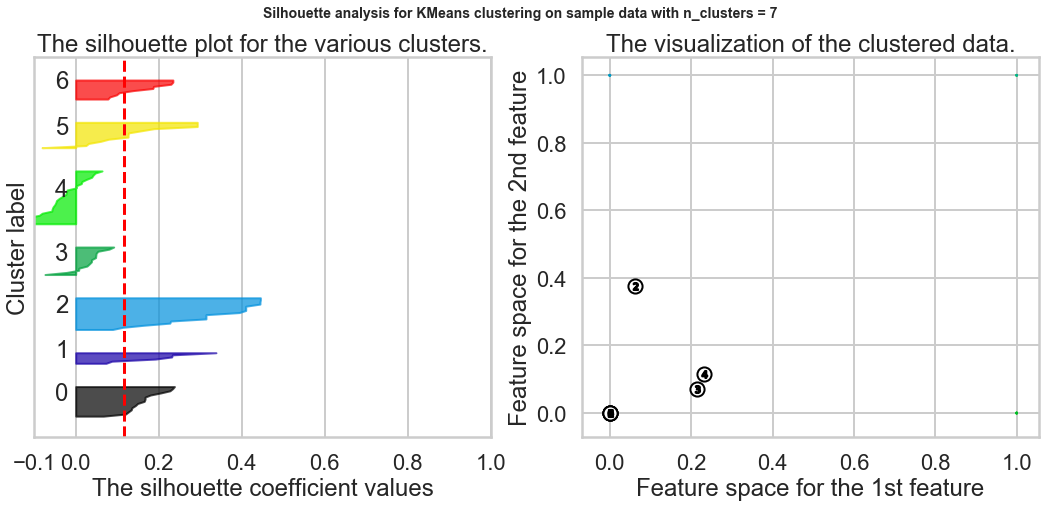

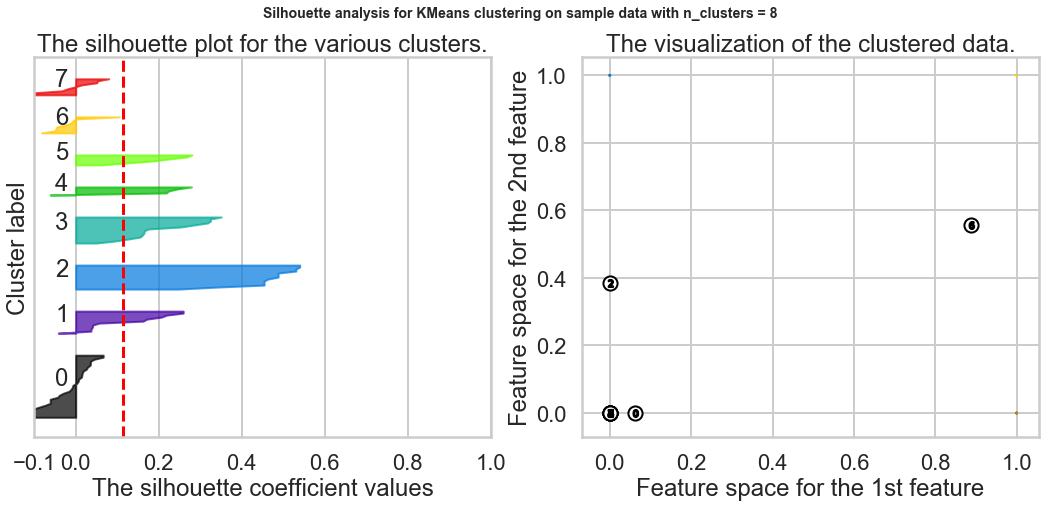

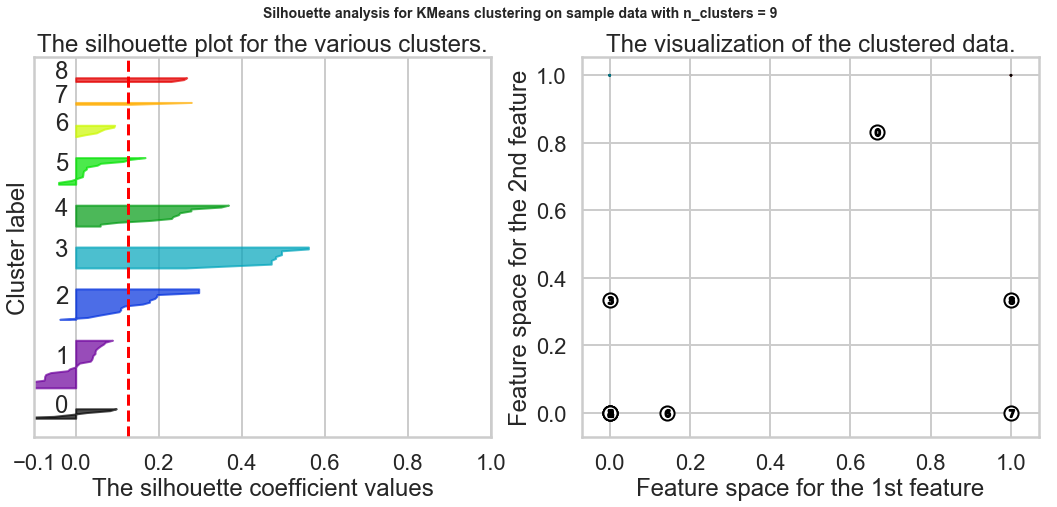

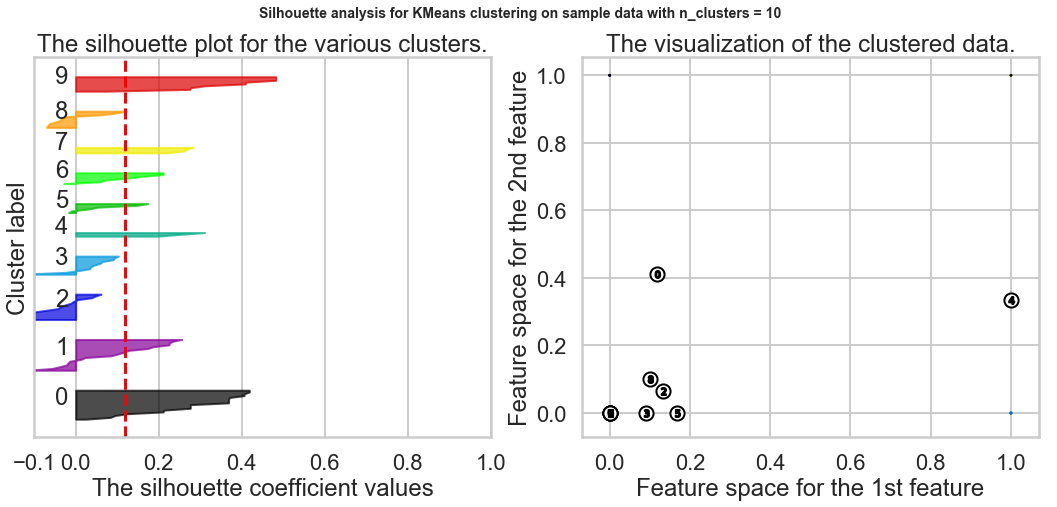

In [177]:
# Your turn.
X = np.array(matrix.iloc[:,1:])
range_n_clusters = range(2,11)
silhouette_scores = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Text(0,0.5,'Silhoutte Score')

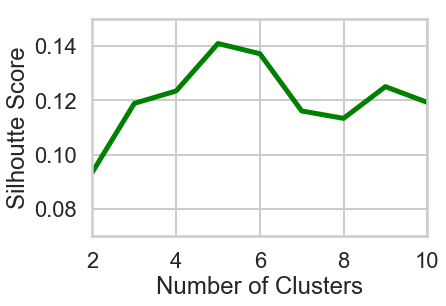

In [178]:
plt.plot(range(2,11),silhouette_scores,color='green',linewidth=5)
plt.ylim(0.07,0.15)
plt.xlim(2,10)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhoutte Score')

<div class="span5 alert alert-success">

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighbor clusters. The measure is in a range between -1 and 1. With +1 indicating that the sample is far away from the neightboring clusters, and 0 indicates that the sample is on or very close. 

From our graph we can see that all the scores are close to 0, indicating that none of the clusters are very effective

</div>


### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [238]:
#your turn
from sklearn.decomposition import PCA 

pca = PCA(n_components=2)
pca_components = pca.fit_transform(x_cols)
x = pca_components[:,0]
y = pca_components[:,1]

In [239]:
dfpca = pd.DataFrame()
dfpca['customer name'] = matrix['customer_name']
dfpca['cluster'] = clusters
dfpca['x'] = x
dfpca['y'] = y

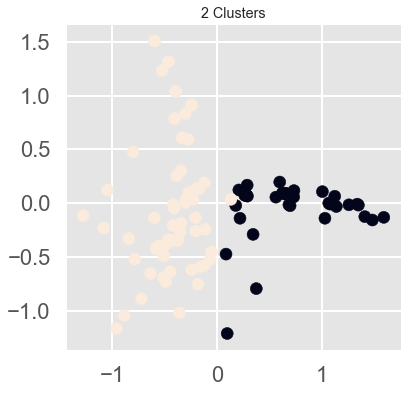

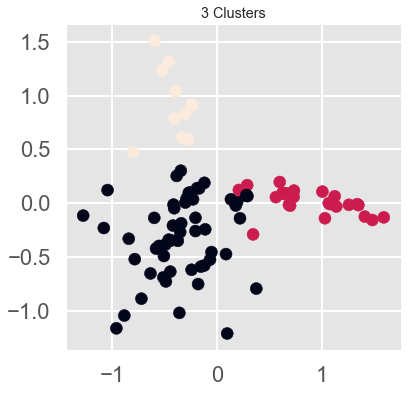

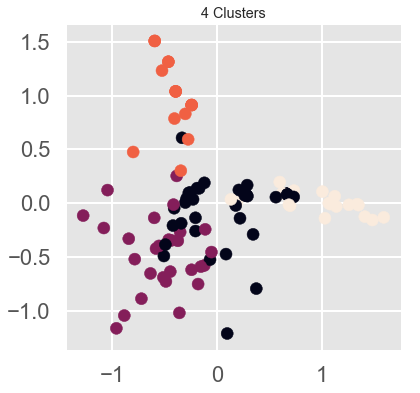

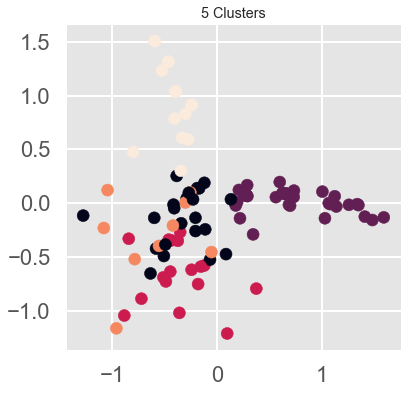

In [240]:
plt.style.use('ggplot')
for K in range(2,6):
    clusters = KMeans(n_clusters=K, random_state =42)
    dfpca['Clusters'] = clusters.fit_predict(x_cols)
    plt.figure(figsize=(6,6))
    plt.scatter(dfpca['x'],dfpca['y'],c = dfpca['Clusters'])
    plt.title('{} Clusters'.format(K))
    plt.show()

<div class="span5 alert alert-success">

Based on what you see, what seems to be the best value for  K ? Moreover, which method of choosing  K  seems to have produced the optimal result visually?

Based off the scatter plots the best choice of K would be 3 clusters. Visually, 3 clusters holds the most effective understandable clustering out of all the other plots. Both the silhouette method and the SS method didn't provide significant results for our clustering, however the SS method matches with our PCA results. Therefore I would choose the SS method to produce the optimal results visually.
</div>


**Exercise:** Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

Since K=3 seems to be our best clustering, I will use it to find any interesting results from our data.

In [242]:
tc_model = KMeans(n_clusters=3)
tc_clusters = best_model.fit_predict(x_cols)
tc_clusters


array([1, 2, 0, 1, 2, 2, 0, 1, 2, 1, 2, 0, 1, 2, 1, 0, 2, 0, 1, 2, 1, 1,
       2, 2, 0, 2, 2, 2, 2, 0, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 0, 0, 1, 2,
       1, 2, 1, 1, 2, 2, 2, 2, 2, 0, 2, 1, 0, 1, 1, 2, 2, 1, 2, 1, 1, 0,
       0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 1, 2,
       1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2], dtype=int32)

In [243]:
pca_tc = PCA(n_components=2)
pca_tc_components = pca.fit_transform(x_cols)
x_tc = pca_tc_components[:,0]
y_tc = pca_tc_components[:,1]

df_tc = matrix[['customer_name']]
df_tc['cluster'] = tc_clusters
df_tc['x'] = x_tc
df_tc['y'] = y_tc

df_tc.head()

/Users/matthewwong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/matthewwong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/matthewwong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

offer_id,customer_name,cluster,x,y
0,Adams,1,1.007580,0.108215
1,Allen,2,-0.287539,0.044715
2,Anderson,0,-0.392032,1.038391
3,Bailey,1,0.699477,-0.022542
4,Baker,2,0.088183,-0.471695


In [244]:
df_new = pd.merge(df_transactions, df_tc)
df_new = pd.merge(df_offers,df_new)

In [245]:
df_new.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,cluster,x,y
0,1,January,Malbec,72,56,France,False,Thomas,1,2,-1.041879,0.122314
1,1,January,Malbec,72,56,France,False,Jackson,1,2,-0.839578,-0.328823
2,1,January,Malbec,72,56,France,False,Mitchell,1,2,-0.342938,0.302186
3,1,January,Malbec,72,56,France,False,Peterson,1,0,-0.797379,0.475995
4,1,January,Malbec,72,56,France,False,Wood,1,2,-0.551215,-0.395670


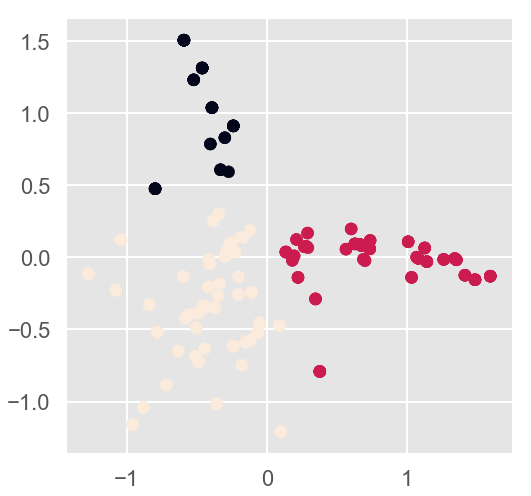

In [247]:
plt.figure(figsize= (8,8))
plt.scatter(df_new['x'],df_new['y'],c=df_new['cluster'])

In [259]:
df_new.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,cluster,x,y,is_3
0,1,January,Malbec,72,56,France,False,Thomas,1,2,-1.041879,0.122314,False
1,1,January,Malbec,72,56,France,False,Jackson,1,2,-0.839578,-0.328823,False
2,1,January,Malbec,72,56,France,False,Mitchell,1,2,-0.342938,0.302186,False
3,1,January,Malbec,72,56,France,False,Peterson,1,0,-0.797379,0.475995,False
4,1,January,Malbec,72,56,France,False,Wood,1,2,-0.551215,-0.395670,False


In [265]:
#explore dataset with clusters

df_new['is_3'] = df_new.cluster == 2
df_new.groupby('is_3').varietal.value_counts()

is_3   varietal          
False  Pinot Noir            37
       Espumante             32
       Prosecco              22
       Malbec                19
       Pinot Grigio          16
       Merlot                 8
       Champagne              7
       Cabernet Sauvignon     2
       Chardonnay             2
True   Champagne             74
       Cabernet Sauvignon    30
       Prosecco              21
       Chardonnay            13
       Malbec                13
       Merlot                12
       Espumante              8
       Pinot Noir             7
       Pinot Grigio           1
Name: varietal, dtype: int64

In [267]:
df_new['is_2'] = df_new.cluster == 1
df_new.groupby('is_2').varietal.value_counts()

is_2   varietal          
False  Champagne             75
       Pinot Noir            44
       Cabernet Sauvignon    30
       Prosecco              23
       Chardonnay            14
       Malbec                14
       Merlot                13
       Espumante              8
       Pinot Grigio           1
True   Espumante             32
       Prosecco              20
       Malbec                18
       Pinot Grigio          16
       Merlot                 7
       Champagne              6
       Cabernet Sauvignon     2
       Chardonnay             1
Name: varietal, dtype: int64

In [268]:
df_new['is_1'] = df_new.cluster == 0
df_new.groupby('is_1').varietal.value_counts()

is_1   varietal          
False  Champagne             80
       Prosecco              41
       Espumante             40
       Cabernet Sauvignon    32
       Malbec                31
       Merlot                19
       Pinot Grigio          17
       Chardonnay            14
       Pinot Noir             7
True   Pinot Noir            37
       Prosecco               2
       Champagne              1
       Chardonnay             1
       Malbec                 1
       Merlot                 1
Name: varietal, dtype: int64

<div class="span5 alert alert-success">

We can explore and see interesting results through grouping the clusters. For example when I grouped the customers in cluster 3 we can see most of the customers purchased offers corresponding to Champagne and Cabernet Sauvignon. Customers in group 2 mostly purchased offers dealing with Espumante. Customers in group 1 mostly purchased offers dealing with Pinot Noir. With these results we can come up with conclusion and other options to optimize customer recommendations or target particular customers based of these conclusions.

</div>

In [266]:
df_new.groupby('is_3').origin.value_counts()

is_3   origin      
False  France          44
       Australia       30
       South Africa    18
       Oregon          16
       Italy           12
       Chile            8
       Germany          8
       California       7
       New Zealand      2
True   France          84
       Chile           29
       Italy           12
       New Zealand     11
       Oregon          10
       Australia        9
       California       9
       Germany          8
       South Africa     7
Name: origin, dtype: int64

In [269]:
df_new.groupby('is_2').origin.value_counts()

is_2   origin      
False  France          91
       Chile           29
       Italy           24
       Australia       22
       Germany         15
       New Zealand     12
       California      11
       Oregon          10
       South Africa     8
True   France          37
       Australia       17
       South Africa    17
       Oregon          16
       Chile            8
       California       5
       Germany          1
       New Zealand      1
Name: origin, dtype: int64

In [270]:
df_new.groupby('is_1').origin.value_counts()

is_1   origin      
False  France          121
       Chile            37
       Australia        26
       Oregon           26
       South Africa     24
       California       14
       Italy            12
       New Zealand      12
       Germany           9
True   Australia        13
       Italy            12
       France            7
       Germany           7
       California        2
       New Zealand       1
       South Africa      1
Name: origin, dtype: int64

Grouped customers based off origin.

In [275]:
df_new.groupby('is_3')[['min_qty','discount']].mean()

,min_qty,discount
is_3,,
False,31.282759,54.600000
True,80.379888,63.435754


**We can also segment numerical features. Based off this we can compare customers of cluster 3 with the other clusters. Customers of cluster 3 buys more quantity than any other customers.**

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

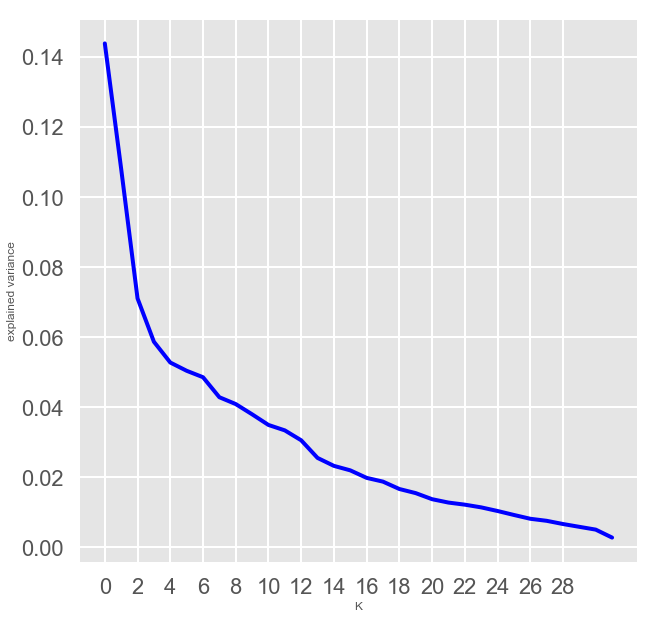

In [284]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Do the rest on your own :)
plt.figure(figsize=(10,10))
plt.plot(pca.explained_variance_ratio_,color='b',linewidth=4)
plt.xticks(np.arange(0,30,2))
plt.xlabel('K')
plt.ylabel('explained variance')
plt.show()


<div class="span5 alert alert-success">

**Exercise:** Using a new PCA object shown in the next cell, plot the explained_variance_ field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?


From the PCA plot the optimal number can be 2. As you can see the curve descent sharply toward 2 then desends slowely downwards. However, we can also notice there is no clear elbow point. 
</div>

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [ ]:
# Your turn

#### Affinity propagation


In [285]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

ap = AffinityPropagation()
ap_model = ap.fit(x_cols)
cc = ap_model.cluster_centers_indices_
n_clusters = len(cc)
labels = ap_model.labels_

print('Number of clusters using Affinity Propagation:',n_clusters)
print('Silhouette Coefficient:', metrics.silhouette_score(x_cols, labels, metric = 'sqeuclidean'))

Number of clusters using Affinity Propagation: 14
Silhouette Coefficient: 0.17978337664151187


#### Spectral Clustering



In [287]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering()
sc_model= sc.fit(x_cols)

labels = sc_model.labels_

print('Silhouette Coefficient:', metrics.silhouette_score(x_cols, labels, metric = 'sqeuclidean'))

Silhouette Coefficient: 0.029308971221948615


#### Agglomerative clustering

In [289]:
from sklearn.cluster import AgglomerativeClustering

ag = AgglomerativeClustering()
ag_model= ag.fit(x_cols)

labels = ag_model.labels_

print('Silhouette Coefficient:', metrics.silhouette_score(x_cols, labels, metric = 'sqeuclidean'))

Silhouette Coefficient: 0.12265266272935


#### DBSCAN



In [290]:
from sklearn.cluster import DBSCAN

ds = DBSCAN()
ds_model= ds.fit(x_cols)

labels = ds_model.labels_

print('Silhouette Coefficient:', metrics.silhouette_score(x_cols, labels, metric = 'sqeuclidean'))

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)